# Q-learning w środowisku "FrozenLake"

### Uczenie przez wzmacnianie
**_Q-learning_** to algorytm uczenia maszynowego typu "uczenie przez wzmacnianie" (_ang. Reinforcement Learning_).
<br> Rodzina takich algorytmów różni się od  uczenia nadzorowanego i nienadzorowanego tym, że informacje do treningu zbieramy nie z danych, a interakcji **agenta** (trenowany algorytm) ze **środowiskiem**.  Funkcja którą kieruje się agent to **polityka** i jako dane wejściowe bierze **obserwację** (np. położenie grasza na planszy, prędkość samochodu na torze) a zwraca **akcję** (np. ruch w prawo, dodanie gazu). 

Dalsza lektura: https://pl.wikipedia.org/wiki/Uczenie_przez_wzmacnianie 

### Klasyczny Q-Learning

Sam Q-learning wytłumaczymy na przykładzie agenta poruszającego się po środowisku typu "FrozenLake".
<br> Weźmy 4x4 elementową planszę: 

In [201]:
import gym 

lake = gym.make('FrozenLake-v1', is_slippery=False)
lake.reset()
lake.render()


SFFF
FHFH
FFFH
HFFG


Legenda:
* (S: *ang. starting point* - punkt startowy , jeden na planszę)
* (F: *ang. frozen surface* - bezpieczne pole)
* (H: *ang. hole* - przerębel, pole, które przyznaj dużą karę, lub kończy rozgrywkę)
* (G: *ang. goal*, punkt końcowy)

Agent zawsze znajduje się na jednym z pól i na podstawie polityki decyduje się na ruch w którąś stronę (lewo, prawo, góra, dół).
Cały spacer skupia się woków nagrody, którą agent zwiększa lub zwiększa wchodząc na określone pole. 
<br> Przykładowa punktacja:
* **Bezpieczne pole**: -0.01 do nagrody (kara w celu wyeliminowania okrężnych dróg, lub chodzenia w kółko)
* **Punkt początkowy**: -0.01 do nagrody
* **Przerębel**: -1 do nagrody
* **Punkt końcowy**: +1 do nagrody

Polityka to funkcja *Q*, która bierze akcję (np. ruch w lewo) i stan (pole nr 5 - drugi rząd od góry, druga kolumna od prawej),
<br> a następnie zwraca nagrodę. W klasycznym przypadku (bez zastosowanie głębokiego uczenia) polityka 
<br> (a dokładniej aktualizacja jej wartości przy każdym kroku) jest reprezentowana przez rówanie Bellmana:

<p><span class="math inline">\(Q^{nowa}(s_{t},a_{t}) \leftarrow \underbrace{Q(s_{t},a_{t})}_{\text{stara wartość}} + \underbrace{\alpha}_{\text{wspł. uczenia}} \cdot  \overbrace{\bigg( \underbrace{\underbrace{r_{t}}_{\text{nagroda za pole}} + \underbrace{\gamma}_{\text{zniżka}} \cdot \underbrace{\max_{a}Q(s_{t+1}, a)}_{\text{oszacowanie optymalnej wartości}}}_{\text{tymczasowa nowa wartość}} - \underbrace{Q(s_{t},a_{t})}_{\text{stara wartość}} \bigg) }^{\text{tymczasowa różnica między starą a nową wartością}}\)</span></p>

Dalsza lektura: https://en.wikipedia.org/wiki/Q-learning

### Deep Q-Learning

Jednak w naszym przypadku korzystamy z tzw. *Deep Q-Learningu* (DQL).
Do podejmowania decyzji używamy sieci neuronowej o 16-elementowym wejściu (ilość pól na planszy) i 4-elementowym wyjściu, odpowiadającemu przewidzianym wagom dla każdego ruchu:
* element 0 - ruch w lewo
* element 1 - ruch w dół
* element 2 - ruch w prawo
* element 3 - ruch w górę

Przykładowo, jeżeli chcemy sprawdzić, w którą stronę najlepiej się ruszyć z pola 5, aktywujemy neuron o indeksie 4

![Przykładowa_sieć](./src/DQL.png)

*Schemat aktywacji na przykładowej sieci*

I same wartości:

In [208]:
agent.Qstate(4)

tensor([0.4165, 0.6063, 0.5308, 0.4209])

Widać tutaj, że najwięszką wartością jest drugi element - agent z tego pola poruszy się w dół.

### Implementacja

Całość została zrealizowana w pytorchu.
Architektura naszego modelu to sieć składająca się z warstw liniowych, przedzielonych sigmoidą jako funkcja aktywacji.
<br> https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html
<br> https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

Jako funkcja straty została użyta:
https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html

Dla wytrenowania modelu wystarcza kilkaset epok. 
<br> Progres treningu śledzimy przez procent tras zakończonych dotarciem do mety po każdej epoce. 
<br> Np. jeżeli średnio 90% tras kończy się na mecie w ostatnich 50 epokach, uczenie możemy uznać za zakończone.
<br> Przykładowa średnia sukcesu przez 50 epok przy treningu przez 1000 epok.

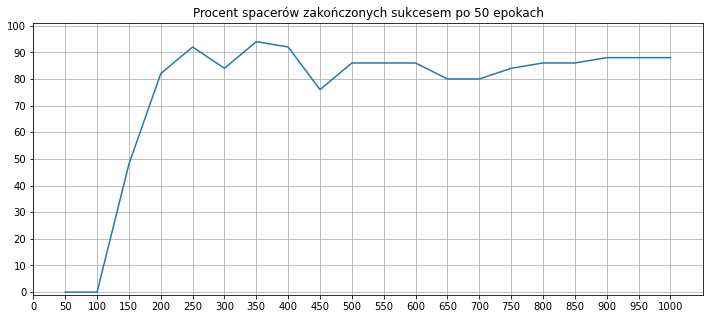

In [229]:
plt.figure(figsize=(12,5))
plt.plot(bin_stat.statistic)
plt.title(label=f'Procent spacerów zakończonych sukcesem po {epoch_bin} epokach')
plt.ylim(-1, 101)
plt.xlim(-1, (epochs+1)/epoch_bin)
plt.yticks(ticks=list(range(0, 110, 10)))
plt.xticks(ticks=bin_stat.bin_edges/epoch_bin-1, labels=bin_stat.bin_edges.astype(int))
plt.grid()
plt.show()

Dodatkowo sprawdzamy czy proces jest optymalny. Dążymy do algorytmu pokonującego trasę w 6 krokach.
<br> Jeżeli jest więcej, algorytm błądzi lub chodzi w kółko. Szukamy momentu, gdzie zaczyna oscylować wokół optymalnej wartości.
<br> Śledzimy więc ile kroków agent wykonuje dzięki polityce po każdej epoce:

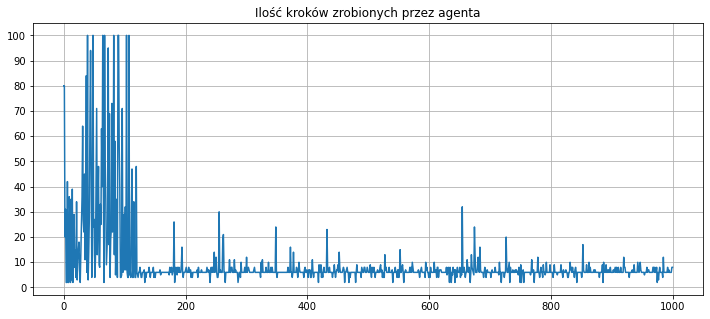

In [227]:
plt.figure(figsize=(12,5))
plt.plot(t.jList)
plt.yticks(ticks=list(range(0, 110, 10)))
plt.title(label="Ilość kroków zrobionych przez agenta")
plt.grid()
plt.show()

Sprawdźmy jak działa wytrenowany agent:

![Agent](./src/agent_walk.gif)